This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [ ]:
NUMBER_OF_BATCHES = 10000
BATCH_SIZE = 20

In [3]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):
        return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        return 1 + rate_val * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
    return tau

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [4]:
alpha_rates = np.linspace(0.01, 1, 10)
tau_values = np.linspace(1, 200, 15)
tau_values

array([  1.        ,  15.21428571,  29.42857143,  43.64285714,
        57.85714286,  72.07142857,  86.28571429, 100.5       ,
       114.71428571, 128.92857143, 143.14285714, 157.35714286,
       171.57142857, 185.78571429, 200.        ])

In [ ]:
def try_different_hyperparams(alpha_rates, tau_values, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_value in enumerate(tau_values):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_value))

            results = results/(BATCH_SIZE * 200)
        
            #records the results
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_value}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            end_winrate = np.mean(results[:, 1][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_value, 'final_winrate': end_winrate}
            df_list.append(new_results)
            #print(f"alpha rate = {alpha_rate}, tau rate = {tau_value}, end winrates = {end_winrate}")
            print(f"{player}_vs_{strategy}: {((b + 1) * (a + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [ ]:
try_different_hyperparams(alpha_rates, tau_values, 'x', 'perfect')
try_different_hyperparams(alpha_rates, tau_values, 'o', 'perfect')
try_different_hyperparams(alpha_rates, tau_values, 'x', 'random')
try_different_hyperparams(alpha_rates, tau_values, 'o', 'random')

NameError: name 'df' is not defined

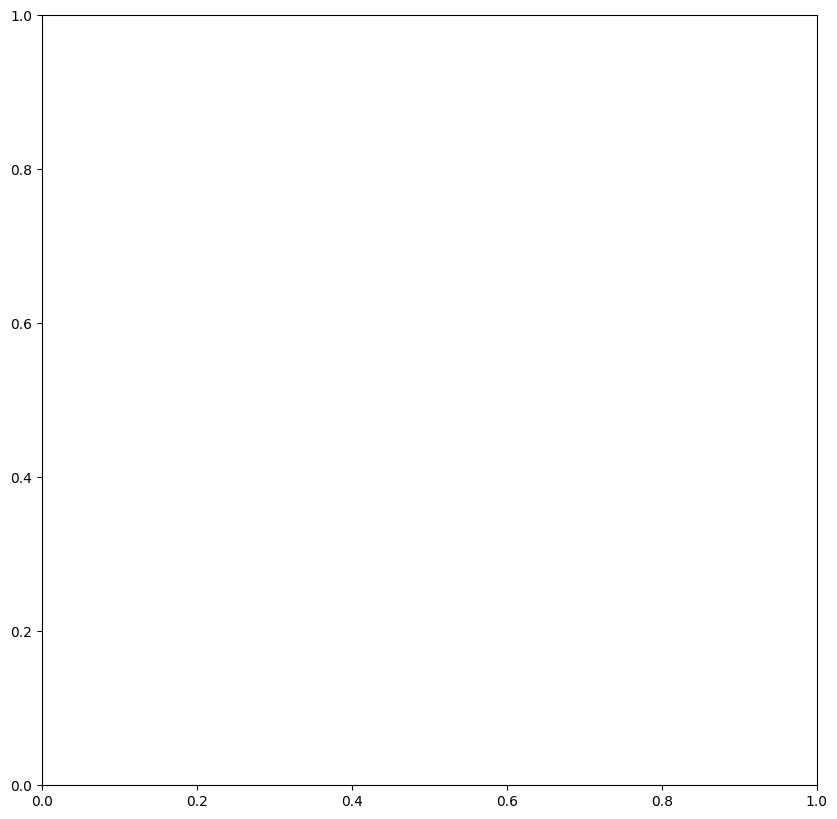

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

x = df['alpha_rate']
y = df['tau_rate']
z = df['final_winrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=20, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label='Final Winrate')